<a href="https://colab.research.google.com/github/mwill20/GAN-Security-Learning/blob/main/notebooks_01_mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding GANs: Creating Fake Digits

In this notebook, we'll learn about GANs by creating one that can draw numbers!

## What's a GAN?
Think of a GAN like two artists:
1. The **Generator** is like a forger trying to create fake money
2. The **Discriminator** is like a bank teller trying to spot fake money

They learn from each other:
- The forger gets better at making fakes
- The teller gets better at spotting fakes

Let's start by setting up our environment and looking at our data!

TensorFlow version: 2.18.0
Running on CPU 🐌

Loaded 60000 MNIST images


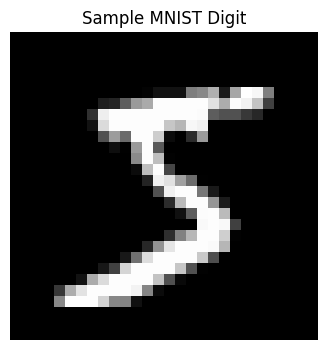

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available! 🚀")
else:
    print("Running on CPU 🐌")

# Load and prepare MNIST dataset
def load_mnist(): # This line loads the MNIST dataset from TensorFlow
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    # The underscores (_) mean we're ignoring those values (they're the labels 0-9)
    # We only want the images, not their number labels
# Scale images to [-1, 1]
    train_images = (train_images - 127.5) / 127.5
    # Original images are 0-255 (black to white)
    # Subtract 127.5 → now values are -127.5 to 127.5
    # Divide by 127.5 → now values are -1 to 1
# GANs work better with data scaled to [-1, 1]
    # Reshape the images
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
    # train_images.shape[0]: number of images (60,000)
    # 28, 28: image dimensions (28x28 pixels)
    # 1: one channel (grayscale). Color would be 3 (RGB)
    return train_images
    # Send back our prepared images

# Load data
train_images = load_mnist()
print(f"\nLoaded {len(train_images)} MNIST images")

# Show a sample image
plt.figure(figsize=(4,4))
plt.imshow(train_images[0].reshape(28,28), cmap='gray')
plt.title("Sample MNIST Digit")
plt.axis('off')
plt.show()

# Demonstrate the data scaling process with visualizations

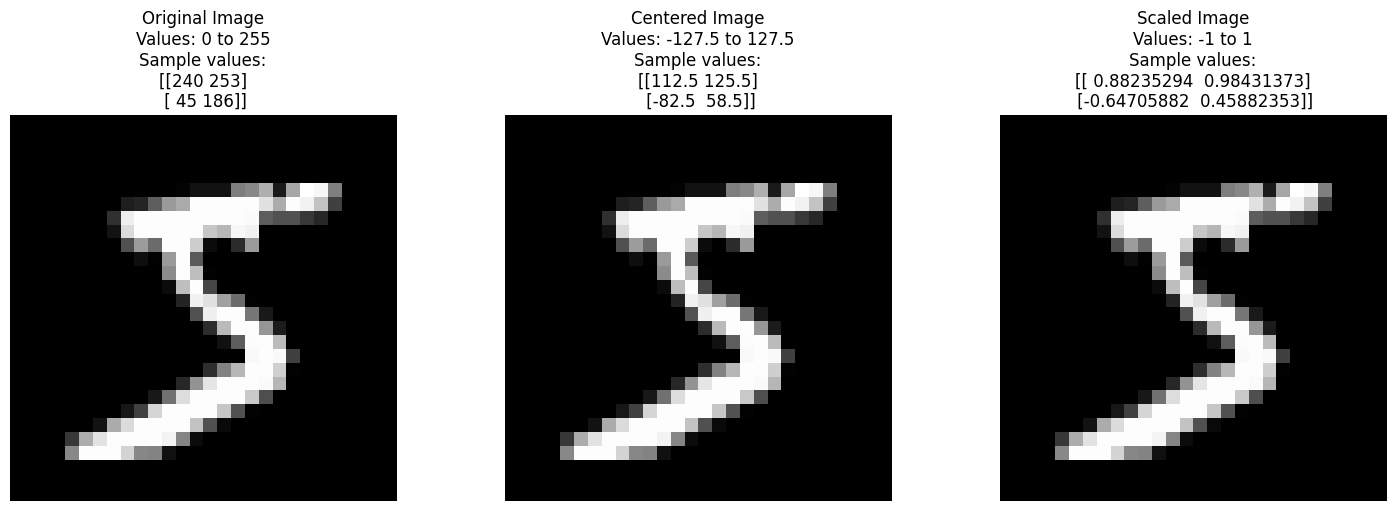


Data Statistics:
Original Image - Min: 0, Max: 255
Centered Image - Min: -127.5, Max: 127.5
Scaled Image - Min: -1.0, Max: 1.0


In [4]:
# Let's see what our data looks like before and after scaling

# Load original images (without scaling)
(raw_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Pick a sample image
sample_idx = 0
original_image = raw_images[sample_idx]

# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# 1. Original Image (0-255)
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f'Original Image\nValues: 0 to 255\nSample values:\n{original_image[14:16, 14:16]}')
plt.axis('off')

# 2. After centering (subtract 127.5)
centered_image = original_image - 127.5
plt.subplot(1, 3, 2)
plt.imshow(centered_image, cmap='gray')
plt.title(f'Centered Image\nValues: -127.5 to 127.5\nSample values:\n{centered_image[14:16, 14:16]}')
plt.axis('off')

# 3. After scaling (divide by 127.5)
scaled_image = centered_image / 127.5
plt.subplot(1, 3, 3)
plt.imshow(scaled_image, cmap='gray')
plt.title(f'Scaled Image\nValues: -1 to 1\nSample values:\n{scaled_image[14:16, 14:16]}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nData Statistics:")
print(f"Original Image - Min: {original_image.min()}, Max: {original_image.max()}")
print(f"Centered Image - Min: {centered_image.min()}, Max: {centered_image.max()}")
print(f"Scaled Image - Min: {scaled_image.min()}, Max: {scaled_image.max()}")

This code will:

* Show the same digit in three different ways
* Display actual pixel values so you can see the scaling
* Print min/max values at each step

The visualization helps us understand:

* How the image looks (doesn't change visually)
* How the values change at each step
* Why scaling to [-1, 1] makes sense

What you'll see is:

* Left: Original image (0 to 255)
* Middle: After centering (-127.5 to 127.5)
* Right: Final scaled version (-1 to 1)

# Explain why scaling to [-1, 1] is important, with a visual demonstration.

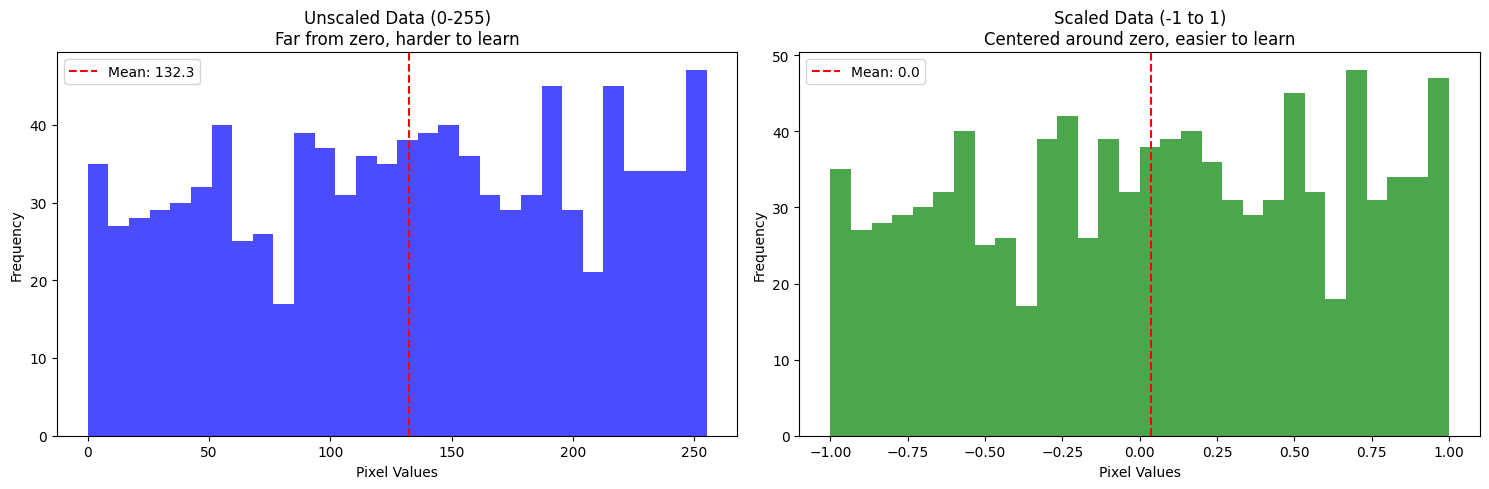


Why scaling helps:
1. Unscaled Data: Mean = 132.3, Std = 73.7
2. Scaled Data: Mean = 0.0, Std = 0.6


In [5]:
# Demonstration of why scaling to [-1, 1] helps

# Create some sample data
np.random.seed(42)  # for reproducibility
unscaled_data = np.random.randint(0, 256, 1000)  # Like our original images (0-255)
scaled_data = (unscaled_data - 127.5) / 127.5    # Scaled to [-1, 1]

# Create figure
plt.figure(figsize=(15, 5))

# 1. Unscaled Data Distribution
plt.subplot(1, 2, 1)
plt.hist(unscaled_data, bins=30, color='blue', alpha=0.7)
plt.axvline(x=unscaled_data.mean(), color='red', linestyle='--', label=f'Mean: {unscaled_data.mean():.1f}')
plt.title('Unscaled Data (0-255)\nFar from zero, harder to learn')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.legend()

# 2. Scaled Data Distribution
plt.subplot(1, 2, 2)
plt.hist(scaled_data, bins=30, color='green', alpha=0.7)
plt.axvline(x=scaled_data.mean(), color='red', linestyle='--', label=f'Mean: {scaled_data.mean():.1f}')
plt.title('Scaled Data (-1 to 1)\nCentered around zero, easier to learn')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("\nWhy scaling helps:")
print(f"1. Unscaled Data: Mean = {unscaled_data.mean():.1f}, Std = {unscaled_data.std():.1f}")
print(f"2. Scaled Data: Mean = {scaled_data.mean():.1f}, Std = {scaled_data.std():.1f}")

Scaling to [-1, 1] helps for several reasons:

1. Centered Around Zero:
* Neural networks learn best when data is centered around 0
* Makes it easier for the network to learn whether something is "more" or "less" than average

2. Consistent Scale:
* All values are between -1 and 1
* Network doesn't have to deal with very large or small numbers
* Helps prevent numerical instability

3. Better Gradients:
* GANs use a special function called 'tanh' that outputs values between -1 and 1
* When our data matches this range, the network learns more efficiently


## You can think of it like this:

* Original (0-255): Like measuring height in different units (inches, feet, yards) all mixed together
* Scaled (-1 to 1): Like converting everything to the same unit, making comparisons easier

The visualization shows:

* Left: Original data spread out far from zero
* Right: Scaled data nicely centered around zero

This is especially important for GANs because:

1. The Generator needs to create images in the same range as real ones
2. The Discriminator needs to compare real and fake images fairly

# Now that we understand our data, let's build our GAN! We'll start with the Generator

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Generator Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,637,121 (6.25 MB)

 Trainable params: 1,636,737 (6.24 MB)

 Non-trainable params: 384 (1.50 KB)

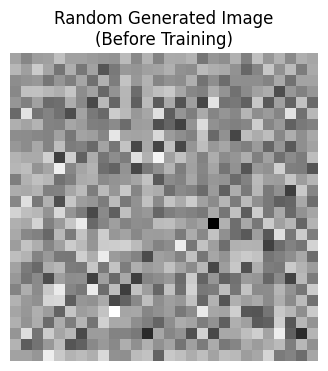


Generated Image Statistics:
Shape: (1, 28, 28, 1)
Min value: -0.155
Max value: 0.063


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_generator():
    # The Generator takes random noise and turns it into images
    model = tf.keras.Sequential([
        # Layer 1: Transform random noise into a dense layer
        # Input: 100 random numbers
        # Output: 12,544 numbers (7 * 7 * 256) that we'll reshape into a small image
        tf.keras.layers.Dense(7 * 7 * 256, input_shape=(100,)),

        # Reshape the dense layer into a small 7x7 image with 256 channels
        # Think of channels like different features of the image
        tf.keras.layers.Reshape((7, 7, 256)),

        # Layer 2: First upsampling block - makes image bigger (7x7 -> 14x14)
        # Conv2DTranspose: Like a reverse convolution, makes image larger
        # kernel_size=3: Look at 3x3 patches
        # strides=2: Double the image size
        # padding='same': Keep the edges of the image
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
        # BatchNormalization: Helps the training stay stable
        tf.keras.layers.BatchNormalization(),
        # LeakyReLU: Helps the generator learn better than regular ReLU
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Layer 3: Second upsampling block - makes image bigger again (14x14 -> 28x28)
        # Same process as above, but with 64 channels instead of 128
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Layer 4: Final layer - creates the actual image
        # Conv2D: Regular convolution to get the final image
        # 1 channel because MNIST is grayscale (would be 3 for RGB)
        # tanh activation: Ensures output is between -1 and 1
        tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='tanh')
    ])

    return model

# Create our generator
generator = make_generator()

# Print a summary of the generator's architecture
print("Generator Architecture:")
generator.summary()

# Test the generator by creating a fake image
# Create 100 random numbers (this is our "noise")
noise = tf.random.normal([1, 100])

# Use the generator to create an image from the noise
generated_image = generator(noise, training=False)

# Display the generated image
plt.figure(figsize=(4,4))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')  # [0,:,:,0] removes extra dimensions
plt.title("Random Generated Image\n(Before Training)")
plt.axis('off')
plt.show()

# Print the shape and value ranges of our generated image
print("\nGenerated Image Statistics:")
print(f"Shape: {generated_image.shape}")
print(f"Min value: {generated_image.numpy().min():.3f}")
print(f"Max value: {generated_image.numpy().max():.3f}")

This code:

* Creats a generator that turns random noise into images
* Show you its structure (how many parameters, layer shapes)
* Generate a random image (will look like noise until trained)
* Show the image's properties

What you see is:

* A detailed summary of the generator's architecture
* A random noisy image (because the generator isn't trained yet)
* Statistics about the generated image


# Now let's build the Discriminator (the part that tries to spot fake images)

In [7]:
def make_discriminator():
    # The Discriminator tries to tell real images from fake ones
    model = tf.keras.Sequential([
        # Layer 1: First Convolution
        # Input: 28x28 image (like MNIST)
        # Output: 14x14 with 64 features
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same',
                             input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.3),  # Helps prevent overfitting

        # Layer 2: Second Convolution
        # Input: 14x14
        # Output: 7x7 with 128 features
        tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.3),

        # Layer 3: Flatten the image
        tf.keras.layers.Flatten(),

        # Layer 4: Final decision
        # Output: 1 number between 0 and 1
        # 1 means "real image", 0 means "fake image"
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create and test the discriminator
discriminator = make_discriminator()

# Print the discriminator's architecture
print("Discriminator Architecture:")
discriminator.summary()

# Test the discriminator with our random image
decision = discriminator(generated_image)
print("\nDiscriminator's verdict on our random image:")
print(f"Probability it's real: {decision.numpy()[0,0]:.3f}")
# Should be around 0.5 since discriminator isn't trained yet

Discriminator Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,769 (315.50 KB)

 Trainable params: 80,769 (315.50 KB)

 Non-trainable params: 0 (0.00 B)


Discriminator's verdict on our random image:
Probability it's real: 0.501


The Discriminator works opposite to the Generator:

* Starts with a 28x28 image
* Makes it smaller while looking for patterns
* Finally decides if the image is real or fake

What you see:

* The Discriminator's architecture
* Its initial guess about our random image (Should be around 0.5 = "not sure")

Now we can see both parts of our GAN:

Generator: Creates fake images from random noise

Discriminator: Tries to spot fake images (currently giving 0.501 probability - basically a random guess!)

# Let's see how the Discriminator handles real MNIST images

Testing Discriminator (numbers show probability of being 'real')


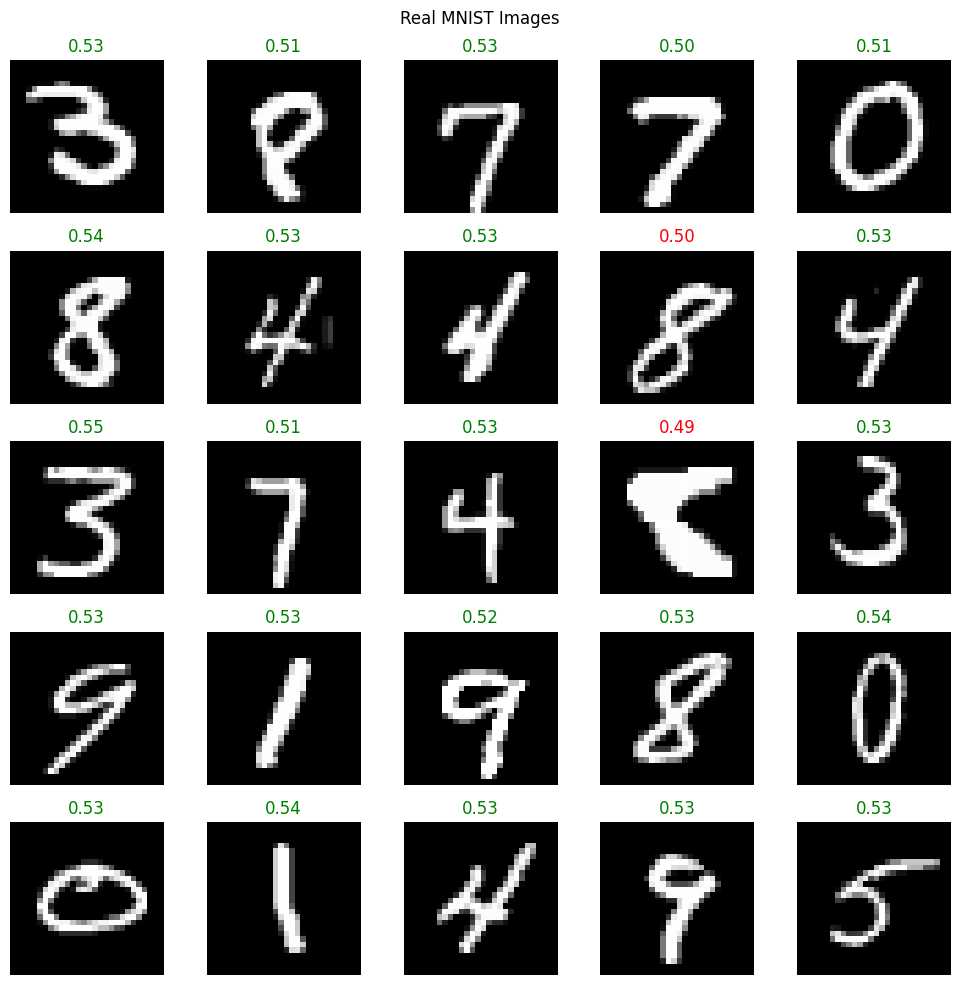

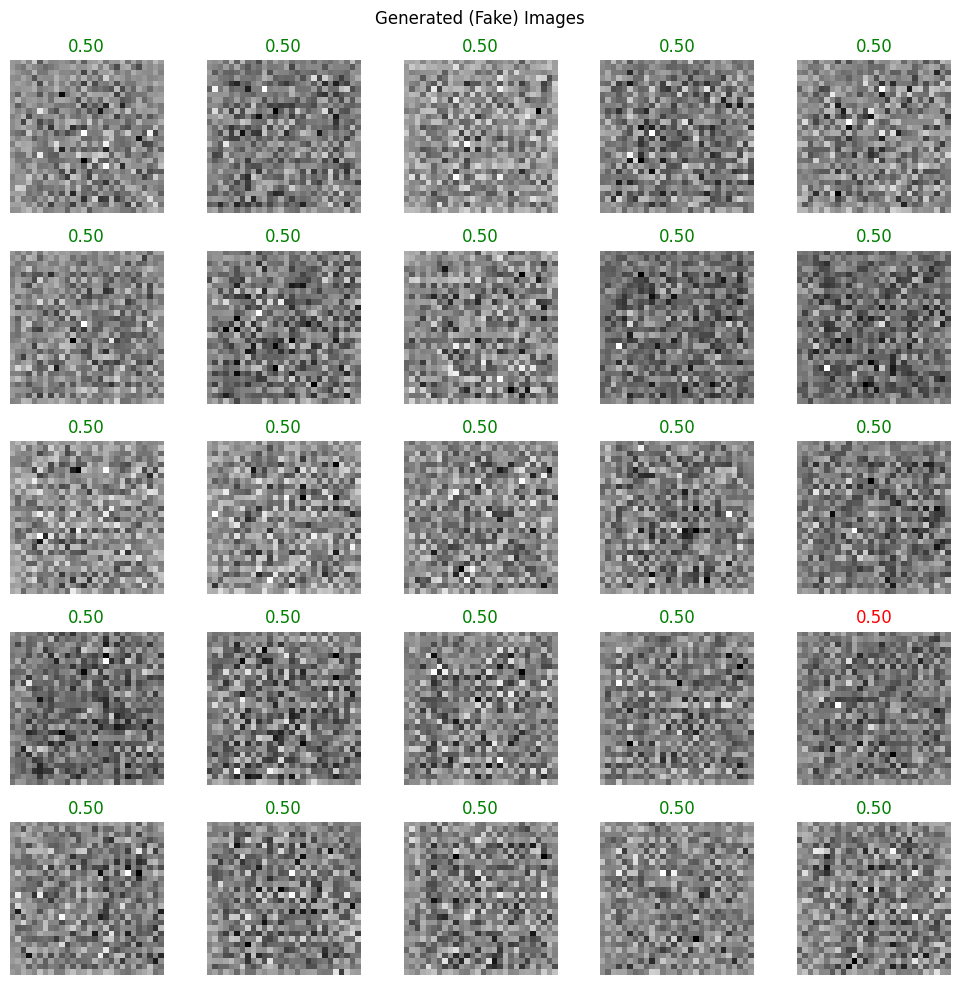


Average prediction for real images: 0.525
Average prediction for fake images: 0.501


In [8]:
# Let's test our Discriminator with real and fake images

# Get some real MNIST images
def get_real_samples(n_samples):
    # Get random images from our training set
    idx = np.random.randint(0, train_images.shape[0], n_samples)
    return train_images[idx]

# Generate some fake images
def get_fake_samples(n_samples):
    # Generate random noise
    noise = tf.random.normal([n_samples, 100])
    # Use generator to create fake images
    fake_images = generator(noise, training=False)
    return fake_images

# Get 25 real and 25 fake images
n_samples = 25
real_images = get_real_samples(n_samples)
fake_images = get_fake_samples(n_samples)

# Test discriminator on both
real_predictions = discriminator(real_images)
fake_predictions = discriminator(fake_images)

# Plotting function
def plot_images_with_predictions(images, predictions, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title(f'{predictions[i,0]:.2f}', color='green' if predictions[i,0] > 0.5 else 'red')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot results
print("Testing Discriminator (numbers show probability of being 'real')")
plot_images_with_predictions(real_images, real_predictions, "Real MNIST Images")
plot_images_with_predictions(fake_images, fake_predictions, "Generated (Fake) Images")

# Print average predictions
print(f"\nAverage prediction for real images: {np.mean(real_predictions):.3f}")
print(f"Average prediction for fake images: {np.mean(fake_predictions):.3f}")

"""This code will:
- Get some real MNIST digits
- Generate some fake images
- Show how the Discriminator rates both

Numbers above each image show:
- Close to 1.0 = "Probably real"
- Close to 0.0 = "Probably fake"
- Around 0.5 = "Not sure"

Since neither network is trained yet, you should see:
- Random predictions (around 0.5)
- Fake images that look like noise
- The Discriminator being very uncertain"""

Next, we'll:
*  Train both networks together
* Watch the Generator get better at making fakes
* Watch the Discriminator get better at spotting them

# Now comes the exciting part - training our GAN!
### We'll create a training loop that lets us watch the Generator improve over time.

In [ ]:
import tensorflow as tf
import time
from IPython.display import clear_output

# Define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizers for both networks
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Training step for the discriminator
def train_discriminator(real_images, batch_size):
    # Create random noise for generator
    noise = tf.random.normal([batch_size, 100])

    # Generate fake images
    generated_images = generator(noise, training=True)

    # Train on real images (label=1.0)
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images, training=True)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)

        # Train on fake images (label=0.0)
        fake_output = discriminator(generated_images, training=True)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        # Total discriminator loss
        disc_loss = real_loss + fake_loss

    # Update discriminator weights
    gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    return disc_loss

# Training step for the generator
def train_generator(batch_size):
    # Create random noise
    noise = tf.random.normal([batch_size, 100])

    # Train generator to fool discriminator
    with tf.GradientTape() as tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        # Generator wants discriminator to think its images are real (label=1.0)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Update generator weights
    gradients = tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return gen_loss

# Function to show progress
def plot_progress(noise_seed, epoch, gen_loss, disc_loss):
    clear_output(wait=True)

    # Generate images from seed noise (same noise each time to see progress)
    generated_images = generator(noise_seed, training=False)

    plt.figure(figsize=(10, 5))

    # Plot generated images
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch+1}\nGenerator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
    plt.show()

# Training loop
def train_gan(epochs=50, batch_size=256):
    # Create fixed noise for progress visualization
    fixed_noise = tf.random.normal([10, 100])

    for epoch in range(epochs):
        start_time = time.time()

        # Train on batches
        for batch in range(0, len(train_images), batch_size):
            # Get real images batch
            real_batch = train_images[batch:batch+batch_size]

            # Train both networks
            disc_loss = train_discriminator(real_batch, batch_size)
            gen_loss = train_generator(batch_size)

        # Show progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            plot_progress(fixed_noise, epoch, gen_loss, disc_loss)
            print(f'Time for epoch {epoch+1}: {time.time()-start_time:.2f} sec')

# Start training!
print("Starting GAN training...")
print("We'll see the Generator's progress every 5 epochs")
print("Watch how the random noise slowly becomes digit-like!")
train_gan(epochs=50)

"""This code will:

Train both networks together:
- Generator tries to create better fakes
- Discriminator tries to spot fakes better

Show progress every 5 epochs:
- Display 10 generated images
- Show how they evolve from noise to digits
- Track both networks' losses

Use the same random noise each time to show progress:
- We can watch specific images evolve
- See how they become more digit-like

When you run this:
- Training will take several minutes
- You'll see images improve every 5 epochs
- Eventually, they should look like real digits!"""

Starting GAN training...
We'll see the Generator's progress every 5 epochs
Watch how the random noise slowly becomes digit-like!


# Save the model

In [ ]:
# Add this cell to save our models
def save_models():
    # Save Generator
    generator.save('generator_model.keras')
    # Save Discriminator
    discriminator.save('discriminator_model.keras')
    print("Models saved!")

# Add this cell to load our models
def load_models():
    global generator, discriminator
    # Load Generator
    generator = tf.keras.models.load_model('generator_model.keras')
    # Load Discriminator
    discriminator = tf.keras.models.load_model('discriminator_model.keras')
    print("Models loaded!")